# Загрузка классических библиотек (если запускаете из Kaggle то не требуется )

In [1]:
!pip install Pillow matplotlib opencv-python-headless torch scikit-learn numpy dill pandas

# Загрузка зависимостей и весов

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install shapely --upgrade
!pip install surya-ocr streamlit sahi ultralytics gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
!gdown https://drive.google.com/uc?id=1vvjDTZDYbwqfwz6nh7-1_ux09o1ZHDGe

Downloading...
From (original): https://drive.google.com/uc?id=1vvjDTZDYbwqfwz6nh7-1_ux09o1ZHDGe
From (redirected): https://drive.google.com/uc?id=1vvjDTZDYbwqfwz6nh7-1_ux09o1ZHDGe&confirm=t&uuid=0ca2ddd0-48aa-4646-aed6-df4ed1bb6cab
To: /kaggle/working/epoch32.pt
100%|████████████████████████████████████████| 104M/104M [00:02<00:00, 41.3MB/s]


In [16]:
yolo_weights = "epoch32.pt"

In [51]:
!gdown https://drive.google.com/uc?id=1XY8aT9LyBKXD-xzli9yVMHeNUTEp4D3e

Downloading...
From: https://drive.google.com/uc?id=1XY8aT9LyBKXD-xzli9yVMHeNUTEp4D3e
To: /kaggle/working/Dataset_final.csv
100%|██████████████████████████████████████| 1.12M/1.12M [00:00<00:00, 65.2MB/s]


In [52]:
import pandas as pd
df = pd.read_csv("Dataset_final.csv", sep=';')

In [53]:
df['Количество полюсов'] = df['Количество полюсов'].fillna('')
df['Общ. количество полюсов'] = df['Общ. количество полюсов'].fillna('')
df['Количество проводников (без заземления)'] = df['Количество проводников (без заземления)'].fillna('')

df['Количество полюсов'] = df['Количество полюсов'].apply(lambda x: str(int(x)) if x != '' else '')
df['Общ. количество полюсов'] = df['Общ. количество полюсов'].apply(lambda x: str(int(x)) if x != '' else '')
df['Количество проводников (без заземления)'] = df['Количество проводников (без заземления)'].apply(lambda x: str(int(x)) if x != '' else '')

# Импорт библиотек

In [8]:
import re

from shapely.geometry import box
from PIL import Image
from surya.ocr import run_ocr
from surya.model.detection.model import load_model as load_detection_model, load_processor as load_detection_processor
from surya.model.recognition.model import load_model
from surya.model.recognition.processor import load_processor
import matplotlib.pyplot as plt
import cv2
import torch 
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.predict import get_prediction, get_sliced_prediction
import numpy as np

2024-07-16 19:49:10.843065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 19:49:10.843162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 19:49:10.977919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Объявление функций

In [60]:
rules = {
    "FU": {
        "keywords": [],
        "characteristics": {
            "Номин. ток": {
                "patterns": [r"\d+а", r"\\d+", r"\d+"],
                "extraction": r"\d+",
                "format": r"\d+, а"
            }
        }
    },
    "FV": {
        "keywords": [],
        "characteristics": {
            "Максимальное напряжение переменного тока (АС)": {
                "patterns": [r"\d+в", r"\d+ в"],
                "extraction": r"\d+",
                "format": r"{0}, в"
            },
            "Количество проводников (без заземления)": {
                "patterns": [r"\d+ р", r"\d+р"],
                "extraction": r"\d+",
                "format": r"{0}"
            }
        }
    },
    "ITU": {
        "keywords": [],
        "characteristics": {}
    },
    "KM": {
        "keywords": [],
        "characteristics": {
            "Номин. раб. ток Ie при AC-3, 400 В": {
                "patterns": [r"\d+а", r"\\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "95, а",
                "format": r"\d+, а"
            }
        }
    },
    "PA": {
        "keywords": [],
        "characteristics": {}
    },
    "PM": {
        "keywords": [],
        "characteristics": {}
    },
    "PV": {
        "keywords": [],
        "characteristics": {}
    },
    "QD": {
        "keywords": [],
        "characteristics": {
            "Номин. ток утечки": {
                "patterns": [],
                "extraction": "",
                "default": "0.3, а",
                "format": ""
            },
            "Номин. ток": {
                "patterns": [r"\d+а", r"\\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "40, а",
                "format": r"\d+, а"
            },
            "Тип тока утечки": {
                "patterns": [],
                "extraction": "",
                "default": "ас",
                "format": r"{0}"
            },
            "Номин. напряжение": {
                "patterns": [r"\d+в", r"\d+ в"],
                "extraction": r"\d+",
                "default": "400, в",
                "format": r"{0}, в"
            },
            "Количество полюсов": {
                "patterns": [r"\d+ р", r"\d+р"],
                "extraction": r"\d+",
                "default": "1",
                "format": r"{0}"
            }
        }
    },
    "QF": {
        "keywords": [],
        "characteristics": {
            "Номин. ток": {
                "patterns": [r"с\d+а", r"\d+а", r"с\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "16",
                "format": r"{0}, а"
            },
            "Общ. количество полюсов": {
                "patterns": [r"\d+р", r"\d+ р"],
                "extraction": r"\d+",
                "default": "1",
                "format": r"{0}"
            },
            "Характеристика срабатывания (кривая тока)": {
                "patterns": [r"хар.[авсd]", r"хар. [авсd]", r"([авсd])", r"[авсd]\d+а", r" [авсd] "],
                "extraction": r"[a-d]",
                "default": "с",
                "format": r"{0}"
            }
        }
    },
    "QFD": {
        "keywords": [],
        "characteristics": {
            "Общ. количество полюсов": {
                "patterns": [r"\d+р", r"\d+ р"],
                "extraction": r"\d+",
                "default": "1",
                "format": r"{0}"
            },
            "Номин. ток": {
                "patterns": [r"с\d+а", r"\d+а", r"с\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "16",
                "format": r"{0}, а"
            },
            "Характеристика срабатывания (кривая тока)": {
                "patterns": [r"хар.[авсd]", r"хар. [авсd]", r"([авсd])", r"[авсd]\d+а", r" [авсd] "],
                "extraction": r"[a-d]",
                "default": "с",
                "format": r"{0}"
            }
        }
    },
    "QFU": {
        "keywords": [],
        "characteristics": {
            "Номин. ток": {
                "patterns": [r"\d+а", r"\\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "10, а",
                "format": r"\d+, а"
            }
        }
    },
    "QS": {
        "keywords": [],
        "characteristics": {
            "Количество полюсов": {
                "patterns": [r"\d+р", r"\d+ р"],
                "extraction": r"\d+",
                "default": "1",
                "format": r"{0}"
            },
            "Номин. ток": {
                "patterns": [r"с\d+а", r"\d+а", r"с\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "100, а",
                "format": r"{0}, а"
            }
        }
    },
    "QW": {
        "keywords": [],
        "characteristics": {
            "Количество полюсов": {
                "patterns": [r"\d+р", r"\d+ р"],
                "extraction": r"\d+",
                "default": "1",
                "format": r"{0}"
            },
            "Номин. ток": {
                "patterns": [r"с\d+а", r"\d+а", r"с\d+", r"\d+"],
                "extraction": r"\d+",
                "default": "100, а",
                "format": r"{0}, а"
            }
        }
    },
    "TT": {
        "keywords": [],
        "characteristics": {
            "Вторичный номин. ток": {
                "patterns": [r"\\d+", r" \d+"],
                "extraction": r"\d+",
                "default": "5, а",
                "format": r"{0}, а"
            },
            "Первичный номин. ток": {
                "patterns": [r"\d+\\", r"\d+ \\"],
                "extraction": r"\d+",
                "default": "800, а",
                "format": r"{0}, а"
            }
        }
    },
    "Timer": {
        "keywords": [],
        "characteristics": {}
    },
    "XS": {
        "keywords": [],
        "characteristics": {}
    },
    "YZIP": {
        "keywords": [],
        "characteristics": {}
    },
    "switch": {
        "keywords": [],
        "characteristics": {}
    },
    "Шкаф": {
        "keywords": [],
        "characteristics": {}
    }
}


def rotate_bbox(bbox, angle, image_shape):
    
    x1, y1, x2, y2 = bbox
    if angle == 0:
        return bbox
    
    height, width = image_shape[:2]
    
    if angle == 90:
        new_x1 = y1
        new_y1 = width - x2
        new_x2 = y2
        new_y2 = width - x1
    elif angle == -90:
        new_x1 = height - y2
        new_y1 = x1
        new_x2 = height - y1
        new_y2 = x2
    
    return [new_x1, new_y1, new_x2, new_y2]

def filter_and_check_language(input_text):
   
    non_allowed_chars = re.compile(r'[^a-zA-Zа-яА-Я0-9~`!@#$%^&*()_\-+=\[\]{}|\\:;"\'<>,.?/\s]+')
    non_allowed_matches = non_allowed_chars.findall(input_text)
    contains_other_languages = bool(non_allowed_matches)
    return contains_other_languages

def display_image(title, img, cmap='gray'):
    plt.figure(figsize=(30, 30))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    
def calculate_min_distance(bbox1, bbox2):
    
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    if x1_max < x2_min:
        dx = x2_min - x1_max
    elif x1_min > x2_max:
        dx = x1_min - x2_max
    else:
        dx = 0

    if y1_max < y2_min:
        dy = y2_min - y1_max
    elif y1_min > y2_max:
        dy = y1_min - y2_max
    else:
        dy = 0

    return np.sqrt(dx**2 + dy**2)

def bbox_distance(bbox1, bbox2):
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2

        dx = max(0, x2_min - x1_max, x1_min - x2_max)
        dy = max(0, y2_min - y1_max, y1_min - y2_max)
        return np.sqrt(dx**2 + dy**2)
    
def intersection_area_percentage(bbox1, bbox2):

    box1 = box(bbox1[0], bbox1[1], bbox1[2], bbox1[3])
    box2 = box(bbox2[0], bbox2[1], bbox2[2], bbox2[3])
    
    if not box1.intersects(box2):
        return 0.0
    
    intersection = box1.intersection(box2).area
    area1 = box1.area
    area2 = box2.area
    
    percentage1 = (intersection / area1) * 100
    percentage2 = (intersection / area2) * 100
    
    return max(percentage1, percentage2)

def intersection_area_percentage_two(bbox1, bbox2):

    box1 = box(bbox1[0], bbox1[1], bbox1[2], bbox1[3])
    box2 = box(bbox2[0], bbox2[1], bbox2[2], bbox2[3])
    
    if not box1.intersects(box2):
        return 0.0
    
    intersection = box1.intersection(box2).area
    area1 = box1.area
    
    percentage1 = (intersection / area1) * 100
    
    return percentage1

def contains_more_than_one_digit(text):
    
    return len(re.findall(r'\d', text)) > 1

def detect_rotated_russian(text):
    rotated_chars = "ʁєхʎ⊥ɔʞєǝʚɐ"

    rotated_pattern = re.compile(f"[{rotated_chars}]")

    return bool(rotated_pattern.search(text))

def filter_text(text):
    pattern_1 = re.compile(r'%[-\w]*-Ac|А--|а--|A--|a--|с --|c --', re.IGNORECASE)
    pattern_2 = re.compile(r'%[-\w]*-[ВВГввгBbGg]', re.IGNORECASE)
    pattern_3 = re.compile(r'П\d+\.\d+|\bn\d+\.\d+', re.IGNORECASE)
    pattern_4 = re.compile(r'(-.*?){2,}')

    if (pattern_1.search(text) or pattern_2.search(text) or 
        pattern_3.search(text) or pattern_4.search(text) or 
        detect_rotated_russian(text)):
        return False
    return True
    

def extract_text_around_element(class_label, fbbox, image, margins, angle, fx, fy, eps_x, eps_y, langs, det_processor, det_model, rec_model, rec_processor, display=False ):
    x, y, w, h = fbbox
    fbbox = rotate_bbox([x,y,x+w, y+h], angle, (image.height, image.width))
    x, y, x2, y2 = fbbox
    x, y, x2, y2 = int(x), int(y), int(x2), int(y2)
    image = image.rotate(angle, expand=True)
    margin_x1, margin_y1, margin_x2, margin_y2 = margins
    
#     print(fbbox)
#     print((image.width, image.height))

    expanded_x1 = max(0, x - margin_x1)
    expanded_y1 = max(0, y - margin_y1)
    expanded_x2 = min(image.width, x2 + margin_x2)
    expanded_y2 = min(image.height, y2 + margin_y2)
    
#     print((expanded_x1, expanded_y1, expanded_x2, expanded_y2))
    
    cropped_img = image.crop((expanded_x1, expanded_y1, expanded_x2, expanded_y2))

    numpy_image = np.array(cropped_img)

    img = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    rescaled_img = cv2.resize(img, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)

    gray_img = cv2.cvtColor(rescaled_img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((1, 1), np.uint8)
    dilated_img = cv2.dilate(gray_img, kernel, iterations=1)
    eroded_img = cv2.erode(dilated_img, kernel, iterations=1)

    if display:
        display_image("Processed Image", eroded_img, cmap='gray')

    image_pil = Image.fromarray(cv2.cvtColor(eroded_img, cv2.COLOR_GRAY2RGB))

    with torch.no_grad():
        predictions_original = run_ocr([image_pil], [langs], det_model, det_processor, rec_model, rec_processor)

    concatenated_results = []
    all_bboxes = []
    all_texts = []
    
    for page in predictions_original:
        for line in page.text_lines:
            
            if line.confidence >= 0.6:
                flg = True
                for part in line.text.split('\n'):
                    stripped_text = part.strip()
                    if len(stripped_text) > 1 and filter_text(stripped_text):
                        pass
                    else:
                        flg = False
                if flg: 
                    concatenated_results.append(line)
                    all_bboxes.append(line.bbox)
                    all_texts.append(line.text)
                    
    if display:
        print(all_texts) 
    if not all_bboxes:
        return []
    midpoints = np.array([
        [x1, (y1 + y2) / 2]
        for x1, y1, x2, y2 in all_bboxes
    ] + [[ x2, (y1 + y2) / 2] for x1, y1, x2, y2 in all_bboxes
    ])
    
    if display:

        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(eroded_img, cmap='gray')

        for bbox in all_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

        ax.scatter(midpoints[:, 0], midpoints[:, 1], c='red', marker='o') 

    dbscan_x = DBSCAN(eps=eps_x, min_samples=1, metric='euclidean')
    labels_x = dbscan_x.fit_predict(midpoints[:, 0].reshape(-1, 1))
    
    unique_labels_x = set(labels_x)
    if display:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(np.array(eroded_img), cmap='gray')
        colors_x = plt.cm.get_cmap('viridis', len(unique_labels_x))

        for label_x in unique_labels_x:
            if label_x == -1:
                continue 
            group_x = midpoints[labels_x == label_x]
            ax.scatter(group_x[:, 0], group_x[:, 1], marker='o', label=f'X-Cluster {label_x}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('First Clustering of Midpoints (X-axis)')
        plt.legend()
        plt.show()

    cluster_labels = np.full(len(midpoints), -1, dtype=int)

    next_cluster_label = 0
    for label_x in unique_labels_x:
        if label_x == -1:
            continue  
        group_x_indices = np.where(labels_x == label_x)[0]
        group_x = midpoints[group_x_indices]

        dbscan_y = DBSCAN(eps=eps_y, min_samples=1, metric='euclidean')
        labels_y = dbscan_y.fit_predict(group_x[:, 1].reshape(-1, 1))

        for label_y in set(labels_y):
            if label_y == -1:
                continue  
            group_y_indices = group_x_indices[labels_y == label_y]
            cluster_labels[group_y_indices] = next_cluster_label
            next_cluster_label += 1
            
    if display:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(np.array(eroded_img), cmap='gray')
        unique_labels = set(cluster_labels)
        colors = plt.cm.get_cmap('plasma', len(unique_labels))

        for label in unique_labels:
            if label == -1:
                continue  
            group = midpoints[cluster_labels == label]
            ax.scatter(group[:, 0], group[:, 1], marker='o', label=f'Y-Cluster {label}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Second Clustering of Midpoints (Y-axis within X-clusters)')
        plt.legend()
        plt.show()

    bbox_clusters = []
    for bbox, (lx, ly), (rx, ry), text in zip(all_bboxes, midpoints[:len(all_bboxes)], midpoints[len(all_bboxes):], all_texts):
        left_label_index = np.where((midpoints == [lx, ly]).all(axis=1))[0]
        right_label_index = np.where((midpoints == [rx, ry]).all(axis=1))[0]

        left_label = cluster_labels[left_label_index[0]] if len(left_label_index) > 0 else -1
        right_label = cluster_labels[right_label_index[0]] if len(right_label_index) > 0 else -1

        left_cluster_size = np.sum(cluster_labels == left_label) if left_label != -1 else 0
        right_cluster_size = np.sum(cluster_labels == right_label) if right_label != -1 else 0

        if left_cluster_size >= right_cluster_size:
            chosen_label = left_label if left_label != -1 else right_label
        else:
            chosen_label = right_label if right_label != -1 else left_label

        if chosen_label != -1:
            bbox_clusters.append((bbox, chosen_label, text))
        
        
    if display:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(np.array(eroded_img), cmap='gray')
        cluss = [clus for _, clus,_ in bbox_clusters]
        colors_final = plt.cm.get_cmap('tab10',  len(cluss))
        for label in set(cluss):
            if label == -1:
                continue  
            group = midpoints[cluster_labels == label]
            ax.scatter(group[:, 0], group[:, 1], marker='o', c=[colors_final(label)], label=f'Final Cluster {label}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Final Clusters of Midpoints')
        plt.legend()
        plt.show()
        
    merged_bboxes = {}
    merged_texts = {}
    for bbox, cluster, text in bbox_clusters:
        x1, y1, x2, y2 = bbox
        if cluster not in merged_bboxes:
            merged_bboxes[cluster] = [x1, y1, x2, y2]
            merged_texts[cluster] = [(bbox_distance(fbbox, bbox), text)]
        else:
            mx1, my1, mx2, my2 = merged_bboxes[cluster]
            merged_bboxes[cluster] = [min(x1, mx1), min(y1, my1), max(x2, mx2), max(y2, my2)]
            merged_texts[cluster].append((bbox_distance(fbbox, bbox), text))
    
    for cluster in merged_texts:
        merged_texts[cluster] = ' '.join(text for _, text in sorted(merged_texts[cluster]))

    if display:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(np.array(eroded_img), cmap='gray')

        colors_final = plt.cm.get_cmap('tab10', len(merged_bboxes)*3)

        for idx, (cluster, (x1, y1, x2, y2)) in enumerate(merged_bboxes.items()):
            color = colors_final(idx)
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=color, facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1 - 10, f'Cluster {cluster}: {merged_texts[cluster]}', color=color, fontsize=12, weight='bold')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Merged Bounding Boxes and Text by Clusters')
        plt.show()
    
    distances = {key: bbox_distance(fbbox, merged_bbox) for key, merged_bbox in merged_bboxes.items()}

    sorted_merged_bboxes = sorted(merged_bboxes.items(), key=lambda item: distances[item[0]])
    sorted_distance_text_tuples = [(distances[key], merged_texts[key]) for key, _ in sorted_merged_bboxes]
    
    return sorted_distance_text_tuples

def extract_text_around_element_hor_vert(class_label, bbox, image, margins, fx, fy, eps_x, eps_y, langs, det_processor, det_model, rec_model, rec_processor, display):
    origin = extract_text_around_element(class_label, bbox.copy(), image.copy(), margins, -90, fx, fy, eps_x, eps_y, langs, det_processor, det_model, rec_model, rec_processor, display )
    rotated = extract_text_around_element(class_label, bbox.copy(), image.copy(), margins, 0, fx, fy, eps_x, eps_y, langs, det_processor, det_model, rec_model, rec_processor, display )
    if display:
        print(origin)
        print(rotated)    
        print(" ".join([text for _, text in sorted(origin+rotated)[:5]]))
    return [text for _, text in sorted(origin+rotated)[:5]]


from shapely.geometry import box

def predict_image(image_path, detection_model):
    
    image = read_image(image_path)

    numpy_image = np.array(image)

    img = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((1, 1), np.uint8)
    dilated_img = cv2.dilate(gray_img, kernel, iterations=1)
    eroded_img = cv2.erode(dilated_img, kernel, iterations=1)

    processed_img = cv2.cvtColor(eroded_img, cv2.COLOR_GRAY2RGB)

    sliced_result = get_sliced_prediction(
        image=processed_img,
        detection_model=detection_model,
        slice_height=640,
        slice_width=640,
        overlap_height_ratio=0.8,
        overlap_width_ratio=0.8
    )

    return sliced_result
def calculate_iou(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        rect1 = box(x1, y1, x1 + w1, y1 + h1)
        rect2 = box(x2, y2, x2 + w2, y2 + h2)
        area1 = rect1.area
        area2 = rect2.area
        intersection = rect1.intersection(rect2)
        intersection_area = intersection.area

        return max(intersection_area/area1, intersection_area/area2)
def filter_boxes(detections, iou_threshold=0.6):
    threshold_dict = {    'AUX': 0.24,
    'AVR': 0.28,    'FR': 0.7,
    'FU': 0.4,    'FV': 0.26,
    'HL': 0.32,    'ITU': 0.35,
    'K': 0.28,    'KM': 0.5,
    'M': 0.54,
    'MX': 0.7,
    'OPS': 0.7,
    'PA': 0.27,    'PM': 0.27,
    'PV': 0.28,    'Q': 0.7,
    'QD': 0.7,    'QF': 0.51,
    'QFD': 0.5,    'QFU': 0.7,
    'QS': 0.54,    'QW': 0.7,
    'R': 0.32,    'S': 0.28,
    'TT': 0.7,    'WH': 0.7,
    'XS': 0.7,    'YZIP': 0.27,
    'switch': 0.32    }
    pre_filtered_boxes = []
    for i in detections:
        if i['category_name'] != 'Шкаф':
            if i['category_name'] in threshold_dict and threshold_dict[i['category_name']] <= i['score']:
                pre_filtered_boxes.append(i)

    filtered_boxes = []
    for i in range(len(pre_filtered_boxes)):
        keep = True
        for j in range(len(pre_filtered_boxes)):
            if i != j:
                iou = calculate_iou(pre_filtered_boxes[i]['bbox'], pre_filtered_boxes[j]['bbox'])
                if iou > iou_threshold:
                    if pre_filtered_boxes[i]['score'] < pre_filtered_boxes[j]['score']:
                        keep = False
                        break
        if keep:
            filtered_boxes.append(pre_filtered_boxes[i])

    return filtered_boxes

def draw_boxes(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for detection in detections:
        x, y, w, h = detection['bbox']
        score = detection['score']
        category_name = detection['category_name']

        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
        text = f"{category_name}: {score:.2f}"
        cv2.putText(image, text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

        
def get_filtred_boxes_coco(image_path, model, iou_threshold=0.6, display=True):
    result = predict_image(image_path, model)
    coco_ano = result.to_coco_annotations()
    filtred_coco = filter_boxes(coco_ano, iou_threshold)
    if display:
        draw_boxes(image_path, filtred_coco)
    return filtred_coco

def process_yolo_output(yolo_output, image_path,langs, det_processor, det_model, rec_model, rec_processor, display):
    bboxes = [detection['bbox'] for detection in yolo_output]
    class_labels = [detection['category_name'] for detection in yolo_output]
    scores = [detection['score'] for detection in yolo_output]

    max_dim = max(max(bbox[2], bbox[3]) for bbox in bboxes)
    mmarg = 3.5* max_dim
    margins = [mmarg, mmarg, mmarg, mmarg]
    

    image = cv2.imread(image_path)
    color_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_converted)

    extracted_texts = []
    
    for bbox, class_label in zip(bboxes, class_labels):
        text = extract_text_around_element_hor_vert(class_label, bbox, pil_image, margins, 1, 1, mmarg/12, mmarg/6.5 ,langs, det_processor, det_model, rec_model, rec_processor, display)
        if class_label not in ['WH', 'HL', 'AVR']:
            extracted_texts.append((class_label, text))
       
    return extracted_texts

def get_full_text( image, angle, langs, det_processor, det_model, rec_model, rec_processor, display=False ):
    
    image = image.rotate(angle, expand=True)
    
    numpy_image = np.array(cropped_img)

    img = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    rescaled_img = cv2.resize(img, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)

    gray_img = cv2.cvtColor(rescaled_img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((1, 1), np.uint8)
    dilated_img = cv2.dilate(gray_img, kernel, iterations=1)
    eroded_img = cv2.erode(dilated_img, kernel, iterations=1)

    if display:
        display_image("Processed Image", eroded_img, cmap='gray')
        
    with torch.no_grad():
        predictions_original = run_ocr([image_pil], [langs], det_model, det_processor, rec_model, rec_processor)
    
    for page in predictions_original:
        for line in page.text_lines:
            
            if line.confidence >= 0.6:
                flg = True
                for part in line.text.split('\n'):
                    stripped_text = part.strip()
                    if len(stripped_text) > 1 and filter_text(stripped_text):
                        pass
                    else:
                        flg = False
                if flg: 
                    concatenated_results.append(line)
                    all_texts.append(line.text)
    return all_texts

def get_full_text_vert_hor( image, langs, det_processor, det_model, rec_model, rec_processor, display=False ):
    
    original = get_full_text( image, 0, langs, det_processor, det_model, rec_model, rec_processor, display=False )
    rotated = get_full_text( image, -90, langs, det_processor, det_model, rec_model, rec_processor, display=False )
    
    return original+rotated
    
def remove_extra_spaces(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text


def letter_transform(text):    
    transformations = {
        'A': 'А',  
        'B': 'В',  
        'E': 'Е',       
        'H': 'Н',  
        'K': 'Л',    
        'M': 'М',  
        'O': '0',        
        'P': 'Р',  
        'C': 'С',         
        'T': 'Т',  
        'Y': 'У',         
        'X': 'Х',  
        'a': 'а',          
        'e': 'е',          
        'o': '0',  
        'p': 'р',        
        'c': 'с',  
        'y': 'у',          
        'x': 'х',  
        'з': '3',         
        'б': '6',  
        'I': '1',          
        'l': '1',  
        ']': '1',          
        '|': '1',
        ',': '.',
        'n': 'П'
    }
    transformed_text = ''.join(transformations.get(ch, ch) for ch in text)
    return re.sub(r'\b(\d{2,})4\b', r'\1А',transformed_text)

def letters_list_transform(data):
    return [(key, [letter_transform(item) for item in values]) for key, values in data]

def get_estimates(input):
    
    def find_match(s, pattern):
        match = re.search(pattern, s)
        return match.group(0) if match else None
    
    smet = pd.DataFrame(columns = ['article', 'name', 'price'])
    
    for label, text in input:
        text = " ".join(text).lower()
        r = rules[label]
        keywords = r['keywords']
        chars = r['characteristics']
    
        search_dict = {}
        for charactersitic, p in chars.items():
            found = [find_match(text, mask) for mask in p['patterns']]
            values = [find_match(x, p['extraction']) for x in found if x is not None]
            values = [x for x in values if x is not None]
            if values:
                char = p['format'].format(values[0])
                search_dict[charactersitic] = char
                
        mask =  df['тип элемента'].apply(lambda x: label == x)
        for col, val in search_dict.items():
            mask &= (df[col] == val)
        
        q = df[mask].reset_index(drop=True)
        if q.empty:
            row = {"article": f"Нет в каталоге {label}", 'name': f"{label}",  "price": 0}
        else:
            res = q.loc[q['Базовая цена, ₽'].argmin()]
            row = {'article':res['Артикул'], 'name':res['Наименование'], 'price':res['Базовая цена, ₽']}
        smet = pd.concat([smet, pd.DataFrame.from_records([row])])
        
    grouped = smet.groupby('article').size().reset_index(name='amount')
    smet = pd.merge(smet, grouped, on='article')
    smet['sum'] = smet['price'] * smet['amount']
    smet_unique = smet.drop_duplicates(subset=['article'])
    
    return smet_unique.to_dict(orient='list')

# Загрузка моделей 

In [10]:
threshhold=0.2
yolo_model = AutoDetectionModel.from_pretrained(
        model_type='yolov8',
        model_path=yolo_weights,
        confidence_threshold=threshhold
    )


In [11]:
threshhold=0.2
yolo_model = AutoDetectionModel.from_pretrained(
        model_type='yolov8',
        model_path=yolo_weights,
        confidence_threshold=threshhold
    )

langs = ["ru"]  
det_processor, det_model = load_detection_processor(), load_detection_model()
rec_model, rec_processor = load_model(), load_processor()

preprocessor_config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/154M [00:00<?, ?B/s]

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16


config.json:   0%|          | 0.00/6.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Loaded recognition model vikp/surya_rec on device cuda with dtype torch.float16


preprocessor_config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

# Пайплайн обработки фото

## Введите путь к фалу, который Вы хотите обработать

In [57]:
image_path = '/kaggle/input/electrocv/EKF AI Challenge/482/images/Res/101 (215).JPG'
display = False #если хотите посмотреть на этапы работы модели поставьте dasplay = True

Performing prediction on 2 slices.


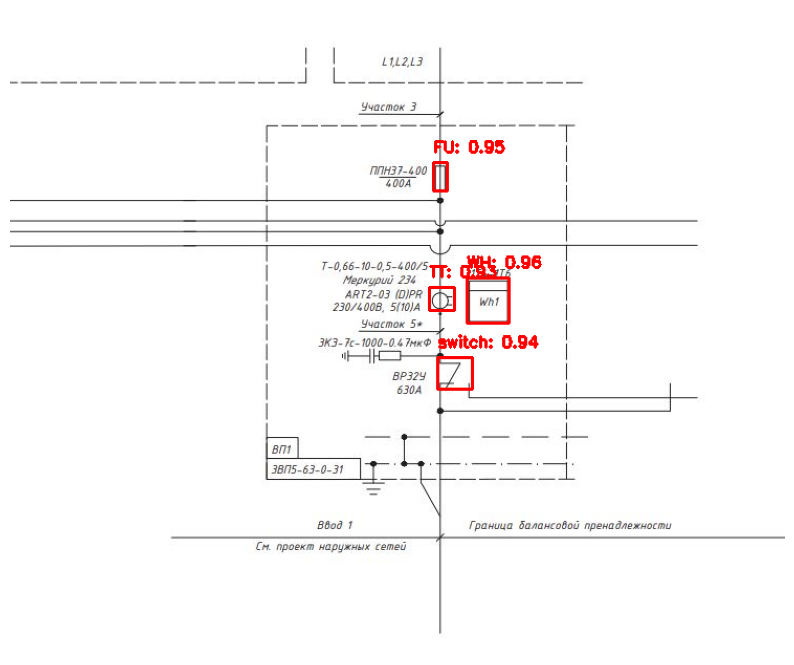

Recognizing Text: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


In [58]:
yolo_output = get_filtred_boxes_coco(image_path, yolo_model, display = True)
res = process_yolo_output(yolo_output, image_path, langs, det_processor, det_model, rec_model, rec_processor, display=display)
res_tr = letters_list_transform(res)
search_res = get_estimates(res_tr)

In [59]:
pd.DataFrame(search_res)

,article,name,price,amount,sum
0,Нет в каталоге,TT,0,2,0
1,uvr32-31b71250,Выключатель-разъединитель ВР32У-31В71250 100А ...,5260,1,5260


In [62]:
pd.DataFrame(search_res)

,article,name,price,amount,sum
0,Нет в каталоге TT,TT,0,1,0
1,Нет в каталоге FU,FU,0,1,0
2,uvr32-31b71250,Выключатель-разъединитель ВР32У-31В71250 100А ...,5260,1,5260
